# Reproduce the https://coronavirus.data.gov.uk/ maps, with an inset for Lancashire and South Cumbria areas

Based on Michael Allen's geopandas_2_inset_map.ipynb 

for now, manual steps:
1. In haste, couldn't see LTLA boundaries on geoportal.statistics.gov.uk, but got Local_Authority_Districts_(December_2020)_UK_BUC.zip.  Upload that from parent CEO folder to data folder here.
1. Grab the latest newCasesBySpecimenDateRollingRate, save to "AMC_Rates.csv" and upload to data folder here. I got from WebData tab of Coronavirus_Data_CaseRates_auto.xlsx.  

Things to develop further:
1. fix glitch with a few missing UK LTLAs (to do with the LAD boundaries?)
1. Change map to a discrete scale to match https://coronavirus.data.gov.uk/details/interactive-map/cases?
1. Make the colours match https://coronavirus.data.gov.uk/details/interactive-map/cases?
1. Change the AMC_Rate.csv step to an API call directly from https://api.coronavirus.data.gov.uk/v2/data?areaType=ltla&metric=newCasesBySpecimenDateRollingRate&format=csv
1. Position UK map better to allow space for LSC map underneath, so no need for negative y value
1. Make sure png export contains all map (point above may fix)
1. Consider adding a box to highlight LSC area on uk map
1. Tweak the max axes on inset map to make bounding box bigger and allow more space for LSC title (or just drop title)
1. Add LTLA names to LSC map
1. Add a basemap to UK map to show some place names
1. rename newCasesBySpecimenDateRollingRate to something shorter


## Import modules

In [2]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, 
                                                   InsetPosition,
                                                   mark_inset)

In [4]:
# Import Shape file that contains LTLAs for UK
filename = "zip://./data/Local_Authority_Districts_(December_2020)_UK_BUC.zip"
ltla_gdf = geopandas.read_file(filename, crs='EPSG:27700')

In [10]:
# Import the Coronavirus rates () - aim to change this to an API call to get latest data
rates = pd.read_csv('./data/AMC_Rates.csv')

In [32]:
# Merge rates
uk_gdf = ltla_gdf.merge(
    rates[['areaCode', 'newCasesBySpecimenDateRollingRate']], left_on='LAD20CD', right_on='areaCode', how='left')

In [33]:
#create a new GeoDataFrame containing only Lancashire and Cumbria LTLAs (better to use codes to avoid the Wyre Forest issue!)
region = "Barrow-in-Furness|Ribble Valley|South Ribble|Rossendale|Wyre|Fylde|Preston|Chorley|" + \
"West Lancashire|Blackpool|Blackburn with Darwen|Hyndburn|Lancaster|Burnley|Pendle|South Lakeland"
mask = (uk_gdf['LAD20NM'].str.contains(region)) & (uk_gdf['LAD20NM'] != "Wyre Forest")
lsc_gdf = uk_gdf[mask]
#lsc_gdf.plot(figsize=(12,6));

In [34]:
rate_max = uk_gdf.newCasesBySpecimenDateRollingRate.max()

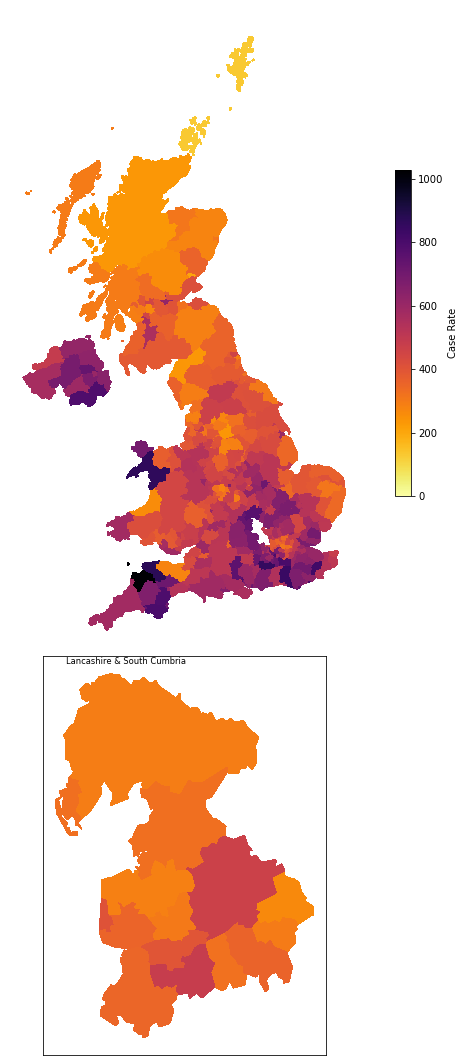

In [52]:
# Create a combined map
# Currently a continuous scale.  Change to a discrete one to match https://coronavirus.data.gov.uk/details/interactive-map/cases?
# fix glitch with a few missing LTLAs (to do with the LAD boundaries?)

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, 
                                                   InsetPosition,
                                                   mark_inset)

#create figure and main axes objects
fig, ax1 = plt.subplots(figsize=(12,12))

#plot data
ax1 = uk_gdf.plot(antialiased=False, # Avoids artifact boundry lines
                            edgecolor='face', # Make boundary same colour as area
                            legend=True, 
                            vmin=0,
                            vmax=rate_max, # Manual scale max (remove to make automatic)
                             cmap='inferno_r', # Colour map to use
                             legend_kwds={'shrink':0.5, 
                                          'label':'Case Rate'},
                            column='newCasesBySpecimenDateRollingRate',
                            ax=ax1)


#create the inset
ax2 = plt.axes([0,0,1,1])

#set the lower left x, y location and relative size of the bounding box
#note these are in fractional units.
ip = InsetPosition(ax1, [0.1,-0.7,0.8,0.8])
ax2.set_axes_locator(ip)

#plot the LSC inset
ax2 = lsc_gdf.plot(antialiased=False, # Avoids artifact boundry lines
                            edgecolor='face', # Make boundary same colour as area
                            legend=False, 
                            vmin=0,
                            vmax=rate_max, # Manual scale max (remove to make automatic)
                             cmap='inferno_r', # Colour map to use
                            column='newCasesBySpecimenDateRollingRate',
                            ax=ax2)

#manual text within inset
#use the axes values in the above plot as a gauge for what 
#values to use to get the required position
ax2.text(320000, 515000,'Lancashire & South Cumbria', fontsize='small')

#formatting tweaks...

#align legend left
leg = ax1.get_legend()

#hide axis tick marks
ax2.tick_params(axis=u'both', which=u'both',length=0)

#hide axis lat long labels, but keep bounding box
ax2.set_xticklabels([])
ax2.set_yticklabels([])

#hide the box and axis labels
ax1.set_axis_off()
plt.savefig('AMc_map.png', dpi=300) # Save figure
plt.show()